# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

/var/folders/qm/9g2hk89d5z9dr27247qqdw0h0000gn/T/ipykernel_41909/1358978034.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-05-22 16:38:09.531953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define the backtest symbol and days to predict and days to look back

In [2]:
ticker_symbol = 'GC=F'
future_steps = 48
look_back = 1
np.random.seed(7)

# Define the function to preprocess the data    

In [3]:
def new_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0:4] 
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0:4])
    return np.array(dataX), np.array(dataY)

# Build the model   

In [4]:
model = Sequential([
    LSTM(100, input_shape=(look_back, 4), return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(4) 
])
model.compile(loss='mean_squared_error', optimizer='adam')
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)

# Get the data from Yahoo Finance

In [5]:
ETH_Ticker = yf.Ticker(ticker_symbol)
ETH_Data = ETH_Ticker.history(period="max", interval="1wk")


# Preprocess the data

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = ETH_Data.iloc[:-future_steps, 0:4].values
scaled_data = scaler.fit_transform(dataset)
trainX, trainY = new_dataset(scaled_data, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 4))


# Train the model

In [7]:
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2, callbacks=[early_stopping])


Epoch 1/200
1189/1189 - 8s - loss: 0.0474 - 8s/epoch - 6ms/step
Epoch 2/200
1189/1189 - 4s - loss: 0.0053 - 4s/epoch - 3ms/step
Epoch 3/200
1189/1189 - 4s - loss: 0.0042 - 4s/epoch - 3ms/step
Epoch 4/200
1189/1189 - 4s - loss: 0.0041 - 4s/epoch - 3ms/step
Epoch 5/200
1189/1189 - 4s - loss: 0.0038 - 4s/epoch - 3ms/step
Epoch 6/200
1189/1189 - 4s - loss: 0.0033 - 4s/epoch - 3ms/step
Epoch 7/200
1189/1189 - 4s - loss: 0.0029 - 4s/epoch - 3ms/step
Epoch 8/200
1189/1189 - 4s - loss: 0.0029 - 4s/epoch - 3ms/step
Epoch 9/200
1189/1189 - 4s - loss: 0.0026 - 4s/epoch - 3ms/step
Epoch 10/200
1189/1189 - 4s - loss: 0.0026 - 4s/epoch - 3ms/step
Epoch 11/200
1189/1189 - 4s - loss: 0.0023 - 4s/epoch - 3ms/step
Epoch 12/200
1189/1189 - 4s - loss: 0.0021 - 4s/epoch - 4ms/step
Epoch 13/200
1189/1189 - 4s - loss: 0.0020 - 4s/epoch - 3ms/step
Epoch 14/200
1189/1189 - 4s - loss: 0.0020 - 4s/epoch - 3ms/step
Epoch 15/200
1189/1189 - 4s - loss: 0.0019 - 4s/epoch - 3ms/step
Epoch 16/200
1189/1189 - 4s - loss

# Predict the future price day by day

In [8]:
predictedValues = np.array([])
currentStep = trainX[-1:] 

for i in range(future_steps):
    nextStep = model.predict(currentStep)
    currentStep = np.append(currentStep[:, 1:, :], nextStep.reshape(1, 1, 4), axis=1)
    predictedValues = np.append(predictedValues, nextStep)
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)


1/1 [==============================] - 2s 2s/step
1189/1189 - 5s - loss: 0.0012 - 5s/epoch - 4ms/step
1/1 [==============================] - 0s 31ms/step
1189/1189 - 5s - loss: 0.0011 - 5s/epoch - 4ms/step
1/1 [==============================] - 0s 34ms/step
1189/1189 - 5s - loss: 0.0013 - 5s/epoch - 5ms/step
1/1 [==============================] - 0s 30ms/step
1189/1189 - 5s - loss: 0.0012 - 5s/epoch - 4ms/step
1/1 [==============================] - 0s 31ms/step
1189/1189 - 5s - loss: 0.0012 - 5s/epoch - 4ms/step
1/1 [==============================] - 0s 28ms/step
1189/1189 - 5s - loss: 0.0013 - 5s/epoch - 4ms/step
1/1 [==============================] - 0s 24ms/step
1189/1189 - 4s - loss: 0.0011 - 4s/epoch - 4ms/step
1/1 [==============================] - 0s 29ms/step
1189/1189 - 5s - loss: 0.0013 - 5s/epoch - 4ms/step
1/1 [==============================] - 0s 30ms/step
1189/1189 - 5s - loss: 0.0011 - 5s/epoch - 4ms/step
1/1 [==============================] - 0s 30ms/step
1189/1189 - 5s

# Evaluate the model

In [9]:
predictedValues = np.array(predictedValues).reshape(-1, 4)
result = scaler.inverse_transform(predictedValues)
result = pd.DataFrame(result, columns=['Open', 'High', 'Low', 'Close'])

In [10]:
actualValues = ETH_Data.iloc[-future_steps:, 0:4]
mse = mean_squared_error(actualValues, result)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


Mean Squared Error: 93691.27569900843
Root Mean Squared Error: 306.09030644404345


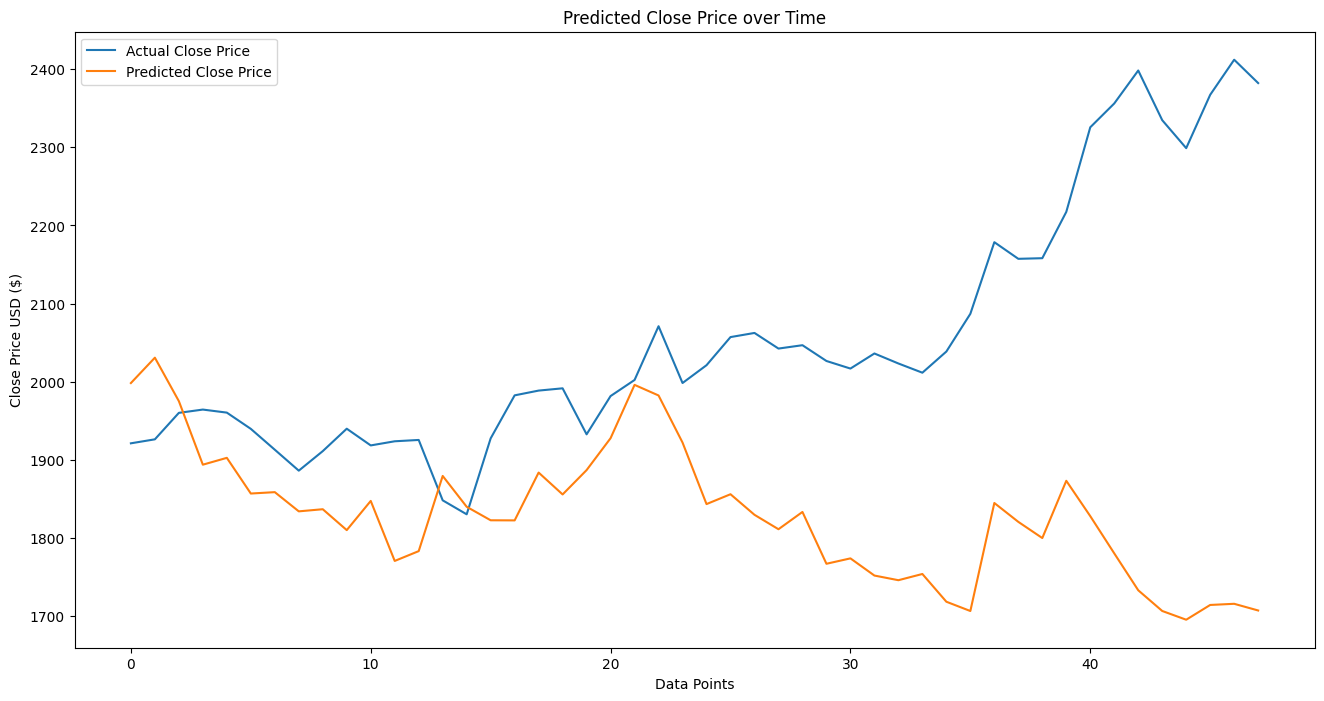

In [11]:
plt.figure(figsize=(16,8))
plt.plot(ETH_Data['Close'][-len(result):].reset_index(drop=True), label='Actual Close Price')
plt.plot(result['Close'], label='Predicted Close Price')

plt.title('Predicted Close Price over Time')
plt.xlabel('Data Points')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()